# Loading in data

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf

train_df =  pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train_df

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


# **Data Description:**
#### The a large set of retina images taken using fundus photography under a variety of imaging conditions. A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

* **0- No DR** 
* **1- Mild**
* **2- Moderate**
* **3- Severe**
* **4- Proliferative DR**

In [2]:
# showing the diagnosis count
(train_df['diagnosis']).value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

# **Preprocessing**

In [3]:
# Converting 'diagnosis' column to string due to "class_mode='categorical'" used below

train_df['diagnosis'] = train_df['diagnosis'].astype(str)

In [4]:
train_df.dtypes

id_code      object
diagnosis    object
dtype: object

In [5]:
# adding ".png" extention to the id_code column;that is how it is stated in train_images folder

train_df['id_code'] = train_df['id_code'] + '.png'

In [6]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


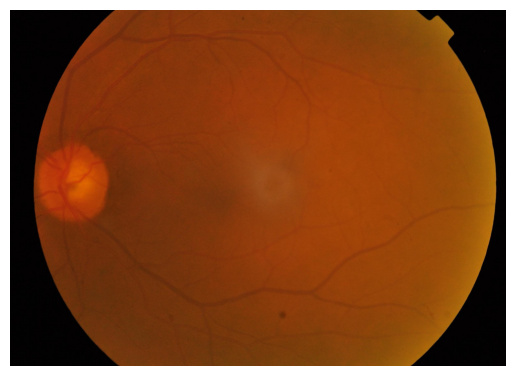

In [7]:
# Loading and displaying an example image
image_path = '/kaggle/input/aptos2019-blindness-detection/train_images/0024cdab0c1e.png'  
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining the image size and batch size
img_size = (256, 256) # resizing the image to 256 x 256
batch_size = 16

# Creating an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # Spliting 20% for validation
    
    #data augmentation parameters
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True 
)

# Load and preprocess the training and validation data
train_generator = datagen.flow_from_dataframe(
    
    dataframe=train_df,
    directory='/kaggle/input/aptos2019-blindness-detection/train_images/',
    x_col='id_code',          # Column in the dataframe that contains image filenames
    y_col='diagnosis',        # Column in the dataframe that contains labels
    target_size=img_size,     # Resizing the images to the specified size
    batch_size=batch_size,    # Number of images to return in each batch
    class_mode='categorical', 
    subset='training'         

)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/aptos2019-blindness-detection/train_images/',
    x_col='id_code',
    y_col='diagnosis',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [9]:
len(validation_generator)

46

# **Building The Model**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Input

In [11]:
# Building a Convolutionary Neural Networ (CNN) model
model = Sequential()

# Defining input layer 
model.add(Input(shape = (256,256,3)))

# Convolutional layer and pooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding more layers
model.add(Conv2D(64, (3,3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3,3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flattening the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(5, activation='softmax'))  # 5 classes for diabetic retinopathy

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,621 (56.61 MB)

 Trainable params: 14,839,621 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

# Compiling the CNN Model

In [12]:
model.compile(
    optimizer='adam',                # Adam optimizer is widely used and effective
    loss='categorical_crossentropy',  # Appropriate loss function for multi-class classification
    metrics=['accuracy']              # Tracking accuracy during training
)


# Training the Model


In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    verbose=1
)
# from tensorflow.keras.models import load_model
model.save('modelb.h5')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726490966.464320      67 service.cc:145] XLA service 0x7bdd54005eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726490966.464378      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/183 ━━━━━━━━━━━━━━━━━━━━ 1:16:03 25s/step - accuracy: 0.1250 - loss: 1.6355

I0000 00:00:1726490971.805563      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/183 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.5051 - loss: 1.5156

I0000 00:00:1726491211.603514      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 52 bytes spill stores, 60 bytes spill loads



183/183 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.5354 - loss: 1.3853 - val_accuracy: 0.6472 - val_loss: 0.9453
Epoch 2/20
  1/183 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6875 - loss: 1.0012

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6875 - loss: 1.0012 - val_accuracy: 0.6667 - val_loss: 0.9072
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.6867 - loss: 0.9196 - val_accuracy: 0.6847 - val_loss: 0.8742
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4375 - loss: 1.4206 - val_accuracy: 0.6667 - val_loss: 0.8263
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.6933 - loss: 0.9102 - val_accuracy: 0.7083 - val_loss: 0.8110
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8750 - loss: 0.6601 - val_accuracy: 0.5000 - val_loss: 1.1173
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.6929 - loss: 0.8394 - val_accuracy: 0.6639 - val_loss: 0.9186
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.6458 - val_accuracy: 0.5833 - val_loss: 1.4185
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.7049 - loss: 0.8509 - val_accuracy: 0.6847 -

# Evaluation

In [14]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6840 - loss: 0.9059
Validation Accuracy: 69.95%
Validation Loss: 0.8415


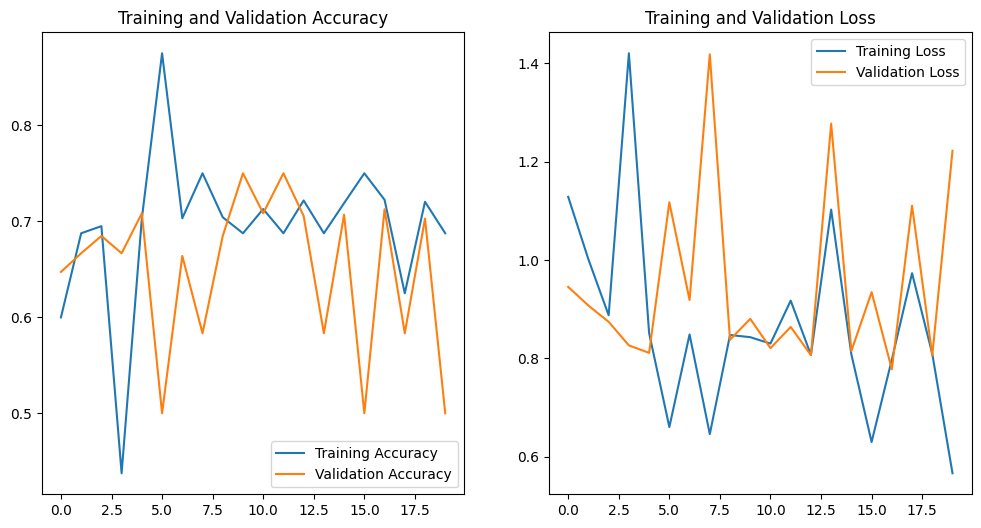

In [15]:
# Plotting training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions from the model
Y_pred = model.predict(validation_generator, steps=len(validation_generator))
y_pred = np.argmax(Y_pred, axis=1)

46/46 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step


In [17]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

# Classification report
print('\n')
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderately Mild', 'Moderately Severe', 'Severe']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[169  10 155   3   0]
 [ 42   1  34   0   0]
 [120   6  94   1   0]
 [ 17   0  21   0   0]
 [ 32   1  25   1   0]]


Classification Report
                   precision    recall  f1-score   support

            No DR       0.44      0.50      0.47       337
             Mild       0.06      0.01      0.02        77
  Moderately Mild       0.29      0.43      0.34       221
Moderately Severe       0.00      0.00      0.00        38
           Severe       0.00      0.00      0.00        59

         accuracy                           0.36       732
        macro avg       0.16      0.19      0.17       732
     weighted avg       0.30      0.36      0.32       732



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
model.save('/kaggle/working/modelb.h5')
